In [ ]:
#***==============================================================
# SOLUTION COMPLÈTE POUR LE TP DE POISSON + HDF5 + VTK + VISUALISATION
#***==============================================================

import numpy as np
import time
import scipy
from scipy import linalg
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#***==============================================================
# 1. Maillage, connectivité, matrice Laplacien et second membre
#***==============================================================

def Maillage(N):
    h = 1./(N+1)
    NTDL = N * N
    Noeuds = np.zeros((NTDL, 2), dtype=int)
    Num = np.zeros((N, N), dtype=int)
    Connect = np.zeros((NTDL, 5), dtype=int)
    k = 0
    for i2 in range(N):
        for i1 in range(N):
            Noeuds[k, :] = [i1, i2]
            Num[i1, i2] = k
            k += 1
    for k in range(NTDL):
        [i1, i2] = Noeuds[k, :]
        m = 0
        if i1 > 0: Connect[k, m+1] = Num[i1 - 1, i2]; m += 1
        if i1 < N-1: Connect[k, m+1] = Num[i1 + 1, i2]; m += 1
        if i2 > 0: Connect[k, m+1] = Num[i1, i2 - 1]; m += 1
        if i2 < N-1: Connect[k, m+1] = Num[i1, i2 + 1]; m += 1
        Connect[k, 0] = m
    return h, NTDL, Noeuds, Connect

def Laplacien(h, NTDL, Connect):
    A = np.zeros((NTDL, NTDL))
    for k in range(NTDL):
        A[k, k] = 4.0 / (h * h)
        for j in range(Connect[k, 0]):
            k2 = Connect[k, j+1]
            A[k, k2] = -1.0 / (h * h)
    return A

def ihs(h, NTDL, Noeuds):
    B = np.zeros(NTDL)
    for k in range(NTDL):
        [i1, i2] = Noeuds[k]
        x1 = (i1 + 1)*h
        x2 = (i2 + 1)*h
        B[k] = np.sin(2 * np.pi * x1) * np.sin(2 * np.pi * x2)
    return B

#***==============================================================
# 2. Export VTK
#***==============================================================

def ecrire_vtk(U, Uex, erreur, N, nom_fichier):
    with open(nom_fichier, "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("Solution approchée\n")
        f.write("ASCII\n")
        f.write("DATASET STRUCTURED_POINTS\n")
        f.write(f"DIMENSIONS {N} {N} 1\n")
        f.write("ORIGIN 0 0 0\n")
        f.write(f"SPACING {1/N} {1/N} 1\n")
        f.write(f"POINT_DATA {N*N}\n")
        
        for name, data in zip(["u", "u_exact", "erreur"], [U, Uex, erreur]):
            f.write(f"SCALARS {name} float 1\n")
            f.write("LOOKUP_TABLE default\n")
            for j in range(N):
                for i in range(N):
                    f.write(f"{data[j, i]}\n")

#***==============================================================
#       3. Programme principal
#***==============================================================

N_tab = np.array([5, 10, 20, 100])
error_list = []
cpu_list = []

fichier = h5py.File("resultats.hdf5", "w")

for i_exp, N in enumerate(N_tab):
    t_init = time.process_time()
    h, NTDL, Noeuds, Connect = Maillage(N)
    A = Laplacien(h, NTDL, Connect)
    B = ihs(h, NTDL, Noeuds)

    lu, piv = linalg.lu_factor(A)
    U = linalg.lu_solve((lu, piv), B)

    Uex = 0.5 * 0.25 * B / (np.pi**2)
    L2error = linalg.norm(U - Uex) * h
    cpu = time.process_time() - t_init

    print(f"\n▶ Résultats pour N = {N}")
    print(f"Erreur L2 = {L2error:.5e}, Temps CPU = {cpu:.3f}s")

    Umat = U.reshape((N, N))
    Uexact = Uex.reshape((N, N))
    erreur = np.abs(Umat - Uexact)

    group = fichier.create_group(f"Sol_N{N}")
    group.attrs["N"] = N
    group.create_dataset("Solution", data=Umat)
    group.create_dataset("Solution_exact", data=Uexact)
    group.create_dataset("Erreur", data=erreur)

    ecrire_vtk(Umat, Uexact, erreur, N, f"solution_{N}.vtk")

    error_list.append(L2error)
    cpu_list.append(cpu)

fichier.create_dataset("L2_error", data=np.array(error_list))
fichier.create_dataset("CPU_Time", data=np.array(cpu_list))
fichier.close()

print("\n Tous les résultats ont été enregistrés dans 'resultats.hdf5' et fichiers .vtk")

# #***==============================================================
# # 4. Visualisation Matplotlib (facultatif mais utile dans le rapport)
# #***==============================================================

# champ = Umat  # pour N = 100, sinon charger avec lire_vtk_structured_points si besoin

# plt.figure(figsize=(6, 6))
# plt.imshow(champ, origin='lower', cmap='coolwarm', extent=[0, 1, 0, 1], interpolation='bilinear')
# plt.colorbar(label="u(x, y)")
# plt.title("Visualisation de la solution approchée (VTK) avec Matplotlib")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()



▶ Résultats pour N = 5
Erreur L2 = 6.11870e-04, Temps CPU = 0.004s

▶ Résultats pour N = 10
Erreur L2 = 1.75022e-04, Temps CPU = 0.001s

▶ Résultats pour N = 20
Erreur L2 = 4.74533e-05, Temps CPU = 0.011s

▶ Résultats pour N = 100
Erreur L2 = 2.04268e-06, Temps CPU = 16.646s

✅ Tous les résultats ont été enregistrés dans 'resultats.hdf5' et fichiers .vtk


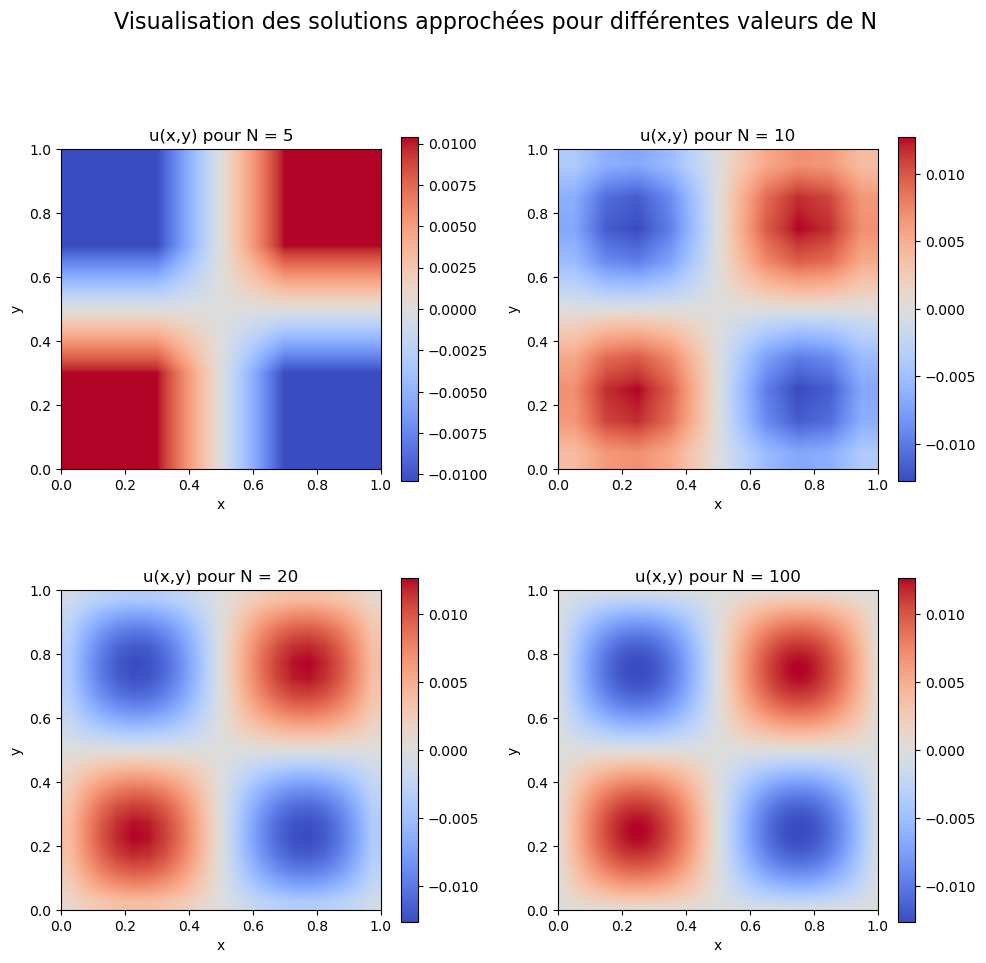

In [ ]:
# 4 _ Visualisation Matplotlib — Grille 2x2 des solutions
#***==============================================================================================

import matplotlib.pyplot as plt

with h5py.File("resultats.hdf5", "r") as fic:
    N_tab = [5, 10, 20, 100]
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    for idx, N in enumerate(N_tab):
        ligne = idx // 2
        colonne = idx % 2
        ax = axes[ligne, colonne]
        
        groupe = fic[f"Sol_N{N}"]
        U = groupe["Solution"][:]

        im = ax.imshow(U, origin='lower', cmap='coolwarm', extent=[0, 1, 0, 1],
                       interpolation='bilinear', aspect='equal')
        ax.set_title(f"u(x,y) pour N = {N}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, shrink=0.8)

    plt.suptitle("Visualisation des solutions approchées pour différentes valeurs de N", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [2]:
import h5py

# Affiche toute la structure du fichier HDF5 (groupes, datasets, attributs)
def explorer_hdf5(fichier_hdf5):
    def afficher_contenu(groupe, indent=0):
        for key in groupe:
            item = groupe[key]
            if isinstance(item, h5py.Dataset):
                print("  " * indent + f"- 📦 Dataset : {key} — shape={item.shape}, dtype={item.dtype}")
            elif isinstance(item, h5py.Group):
                print("  " * indent + f"+ 📁 Groupe : {key}")
                afficher_contenu(item, indent + 1)

    with h5py.File(fichier_hdf5, "r") as f:
        print(f"📂 Contenu de '{fichier_hdf5}' :")
        print("Attributs globaux :")
        for attr in f.attrs:
            print(f"  - {attr} = {f.attrs[attr]}")
        print("\nStructure du fichier :")
        afficher_contenu(f)

# Exemple d'appel
explorer_hdf5("resultats.hdf5")


📂 Contenu de 'resultats.hdf5' :
Attributs globaux :

Structure du fichier :
- 📦 Dataset : CPU_Time — shape=(4,), dtype=float64
- 📦 Dataset : L2_error — shape=(4,), dtype=float64
+ 📁 Groupe : Sol_N10
  - 📦 Dataset : Erreur — shape=(10, 10), dtype=float64
  - 📦 Dataset : Solution — shape=(10, 10), dtype=float64
  - 📦 Dataset : Solution_exact — shape=(10, 10), dtype=float64
+ 📁 Groupe : Sol_N100
  - 📦 Dataset : Erreur — shape=(100, 100), dtype=float64
  - 📦 Dataset : Solution — shape=(100, 100), dtype=float64
  - 📦 Dataset : Solution_exact — shape=(100, 100), dtype=float64
+ 📁 Groupe : Sol_N20
  - 📦 Dataset : Erreur — shape=(20, 20), dtype=float64
  - 📦 Dataset : Solution — shape=(20, 20), dtype=float64
  - 📦 Dataset : Solution_exact — shape=(20, 20), dtype=float64
+ 📁 Groupe : Sol_N5
  - 📦 Dataset : Erreur — shape=(5, 5), dtype=float64
  - 📦 Dataset : Solution — shape=(5, 5), dtype=float64
  - 📦 Dataset : Solution_exact — shape=(5, 5), dtype=float64


In [3]:
pip install h5py h5glance


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


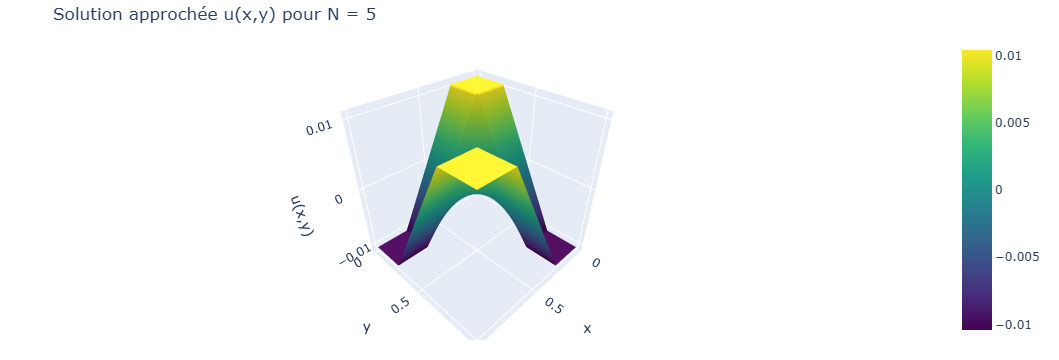

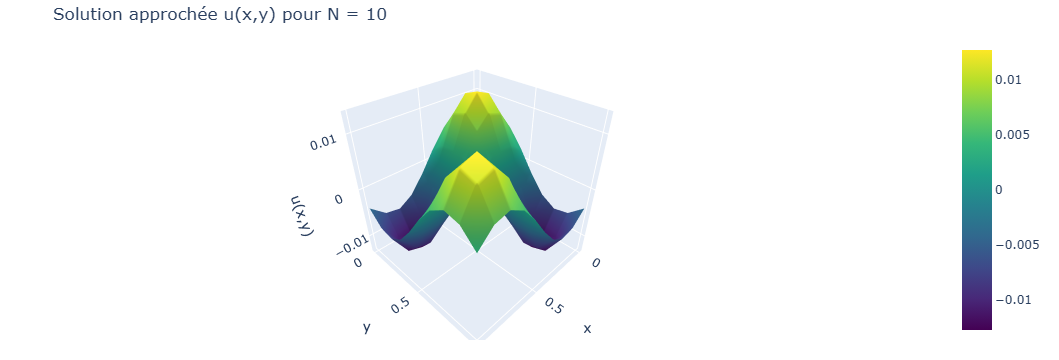

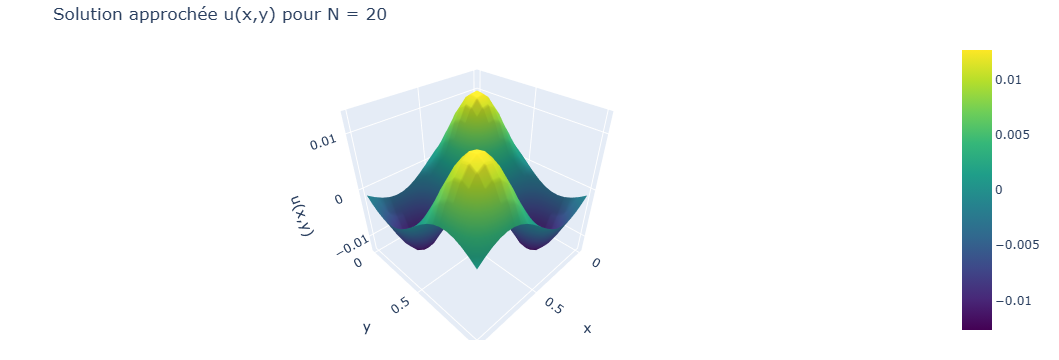

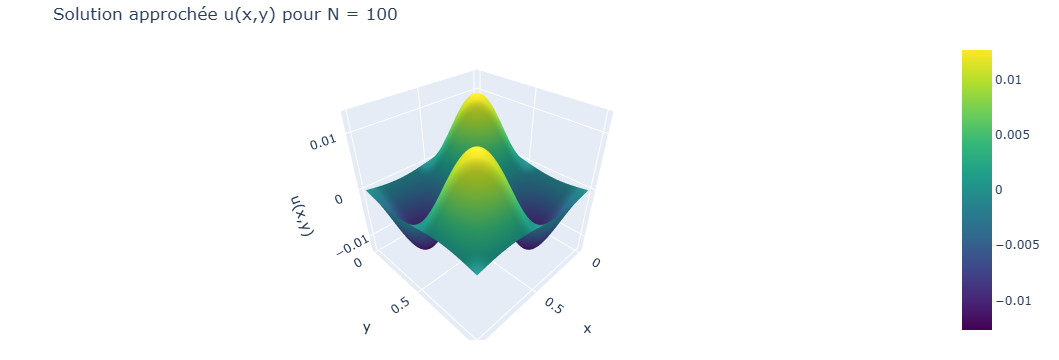

In [4]:
import h5py
import numpy as np
import plotly.graph_objects as go

# === Liste des valeurs de N utilisées ===
N_tab = [5, 10, 20, 100]

# === Lecture et affichage interactif 3D pour chaque N ===
with h5py.File("resultats.hdf5", "r") as f:
    for N in N_tab:
        Z = f[f"Sol_N{N}"]["Solution"][:]
        x = y = np.linspace(0, 1, N)

        fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y, colorscale='Viridis')])
        fig.update_layout(
            title=f'Solution approchée u(x,y) pour N = {N}',
            scene=dict(
                xaxis_title='x',
                yaxis_title='y',
                zaxis_title='u(x,y)',
            ),
            autosize=True,
            margin=dict(l=20, r=20, t=40, b=20)
        )
        fig.show()


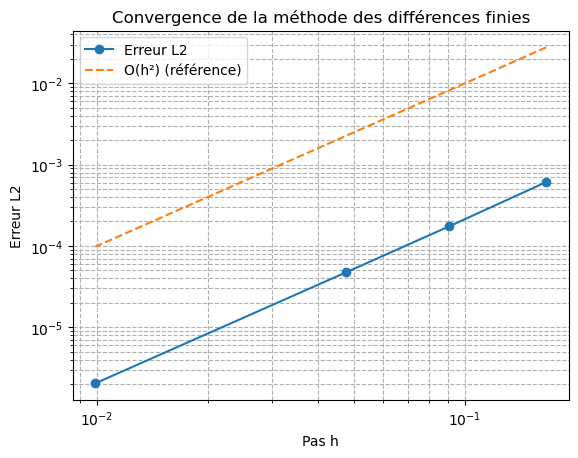

In [5]:
import matplotlib.pyplot as plt

N_tab = np.array([5, 10, 20, 100])
L2_errors = np.array([6.11870e-04, 1.75022e-04, 4.74533e-05, 2.04268e-06])
h_tab = 1. / (N_tab + 1)

plt.figure()
plt.loglog(h_tab, L2_errors, 'o-', label='Erreur L2')
plt.loglog(h_tab, h_tab**2, '--', label='O(h²) (référence)')
plt.xlabel("Pas h")
plt.ylabel("Erreur L2")
plt.title("Convergence de la méthode des différences finies")
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()


In [6]:
from scipy.stats import linregress

slope, intercept, *_ = linregress(np.log(h_tab), np.log(L2_errors))
print(f"Ordre numérique estimé : {slope:.2f}")


Ordre numérique estimé : 2.02


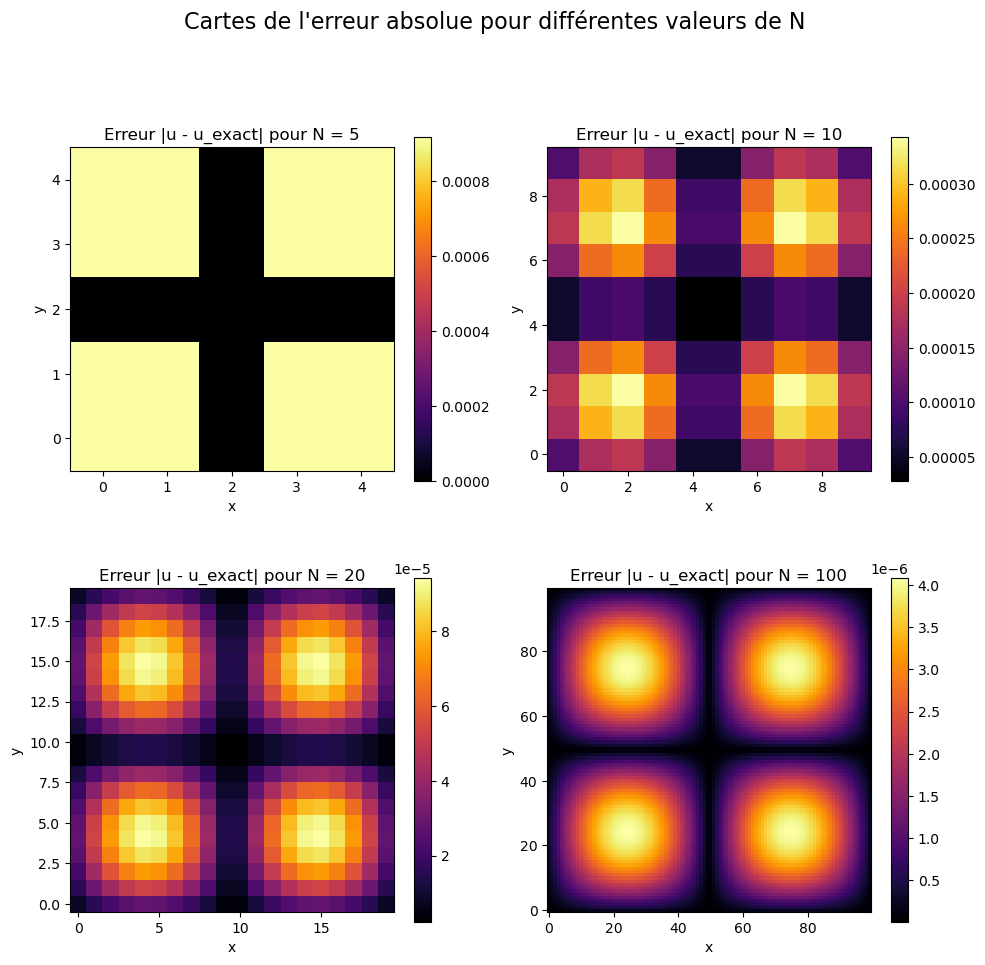

In [7]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

N_tab = [5, 10, 20, 100]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

with h5py.File("resultats.hdf5", "r") as f:
    for idx, N in enumerate(N_tab):
        ligne, colonne = divmod(idx, 2)
        ax = axes[ligne, colonne]

        groupe = f[f"Sol_N{N}"]
        U = groupe["Solution"][:]
        Uex = groupe["Solution_exact"][:]
        erreur = np.abs(U - Uex)

        im = ax.imshow(erreur, cmap='inferno', origin='lower')
        ax.set_title(f"Erreur |u - u_exact| pour N = {N}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Cartes de l'erreur absolue pour différentes valeurs de N", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
